# Install Dependences

In [2]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html
!git clone https://github.com/RR-project-group/TC-AcceleratedMonteCarloSimulation.git

Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
fatal: destination path 'TC-AcceleratedMonteCarloSimulation' already exists and is not an empty directory.


# Import library

In [3]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
os.chdir('TC-AcceleratedMonteCarloSimulation')

/usr/local/lib/python3.11/dist-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


# Detect ColabTPU

In [4]:
# ===== Detect TPU or fallback to CPU/GPU =====
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU Detected.")
    tpu_available = True
except:
    tpu_strategy = tf.distribute.get_strategy()
    print("⚠️ TPU Not Found, running on CPU/GPU.")
    tpu_available = False

✅ TPU Detected.


# BS simulation

25


50


100

📊 Benchmark Results:
          label     dtype  n_steps     price       mse    time
0   CPU-float32   float32       25  3.248831       NaN   9.964
1   CPU-float32   float32       50  3.244731       NaN  19.981
2   CPU-float32   float32      100  3.248410       NaN  39.934
3  TPU-bfloat16  bfloat16       25  3.265625  0.000282   9.148
4  TPU-bfloat16  bfloat16       50  3.234375  0.000107  18.377
5  TPU-bfloat16  bfloat16      100  3.203125  0.002051  36.578


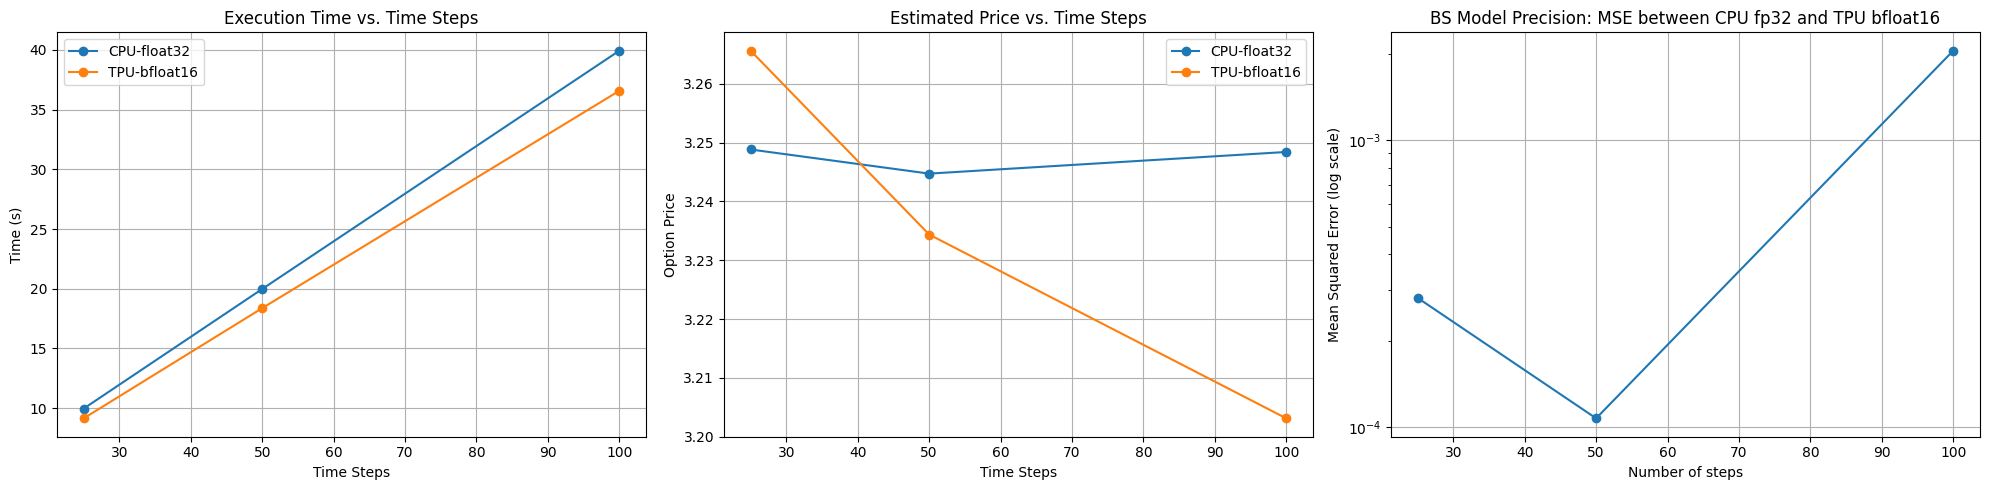

In [5]:
from bs import run_bs_simulation
import pandas as pd

# ===== Parameter Configuration =====
n_steps_list = [25, 50, 100]
n_paths = 10_000_000
dtype = tf.bfloat16
seed = (42, 42)

# Store float32 results as ground truth for MSE calculation
ground_truth_prices = {}

# ===== Run Experiment in Specific Strategy Context =====
def run_experiment(dtype, n_steps, label):
        start = time.time()
        price = run_bs_simulation(n_paths, n_steps, dtype=dtype, seed=seed)
        end = time.time()
        price_value = float(price.numpy())
        # Save ground truth (float32) for later MSE comparison
        if dtype == tf.float32:
            ground_truth_prices[n_steps] = price_value
            mse = None
        else:
            # Compute MSE with respect to float32 ground truth
            gt = ground_truth_prices.get(n_steps)
            mse = (price_value - gt) ** 2 if gt is not None else None
        return {
            "label": label,
            "dtype": str(dtype.name),
            "n_steps": n_steps,
            "price": float(price.numpy()),
            "mse": mse,
            "time": round(end - start, 3)
        }

# ===== Run all configurations =====
results = []

# CPU/GPU: float32 only
for n_steps in n_steps_list:
    result = run_experiment(tf.float32, n_steps, "CPU-float32")
    results.append(result)

# TPU tests: float32 and bfloat16


if tpu_available:
    for n_steps in n_steps_list:
        tf.keras.backend.clear_session()
        with tpu_strategy.scope():
            result = run_experiment(tf.bfloat16, n_steps, f"TPU-{dtype.name}")
        results.append(result)
        print(n_steps)

# ===== Display Results =====
df = pd.DataFrame(results)
print("\n📊 Benchmark Results:")
print(df)

# ===== Optional: Plotting =====
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Execution Time Plot
for key, grp in df.groupby('label'):
    ax[0].plot(grp['n_steps'], grp['time'], marker='o', label=key)
ax[0].set_title("Execution Time vs. Time Steps")
ax[0].set_xlabel("Time Steps")
ax[0].set_ylabel("Time (s)")
ax[0].legend()
ax[0].grid(True)

# Option Price Plot
for key, grp in df.groupby('label'):
    ax[1].plot(grp['n_steps'], grp['price'], marker='o', label=key)
ax[1].set_title("Estimated Price vs. Time Steps")
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()
ax[1].grid(True)

# MSE Plot
for key, grp in df.groupby('label'):
    if grp['mse'].notnull().any():
        ax[2].plot(grp['n_steps'], grp['mse'], marker='o', label=key)
ax[2].set_title("BS Model Precision: MSE between CPU fp32 and TPU bfloat16")
ax[2].set_xlabel("Number of steps")
ax[2].set_yscale('log')
ax[2].set_ylabel('Mean Squared Error (log scale)')
ax[2].grid(True)

plt.tight_layout()
plt.show()

# LMM simulation


Running with 4000 paths...
CPU fp32 time: 0.0070s
TPU bfloat16 time: 0.0061s
MSE: 3.768966e-03

Running with 16000 paths...
CPU fp32 time: 0.1991s
TPU bfloat16 time: 0.1093s
MSE: 3.766622e-03

Running with 64000 paths...
CPU fp32 time: 0.6961s
TPU bfloat16 time: 0.6940s
MSE: 3.758352e-03

Running with 256000 paths...
CPU fp32 time: 2.5956s
TPU bfloat16 time: 2.5977s
MSE: 3.748199e-03


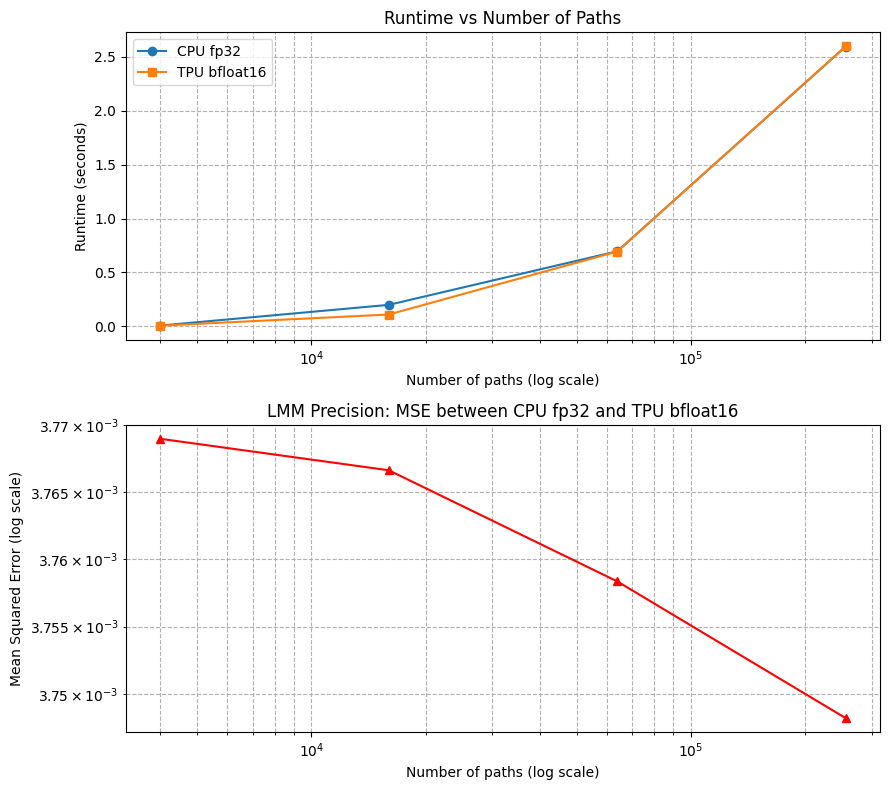

In [7]:
# Disable eager execution for performance
tf.config.experimental_run_functions_eagerly(False)

from lmm import generate_correlation_matrix, simulate_lmm_paths

N = 10
T = 50

corr_np = generate_correlation_matrix(N)
cov_np = corr_np

path_list = [4000, 16000, 64000, 256000]
cpu_times, tpu_times, mse_list = [], [], []

for p in path_list:
    print(f"\nRunning with {p} paths...")

    # CPU fp32
    with tf.device('/CPU:0'):
        start_cpu = time.time()
        res_fp32 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.float32)
        end_cpu = time.time()
        cpu_time = end_cpu - start_cpu
    print(f"CPU fp32 time: {cpu_time:.4f}s")

    cpu_times.append(cpu_time)

    # TPU bfloat16
    if tpu_strategy is not None:
        with tpu_strategy.scope():
            start_tpu = time.time()
            res_bf16 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.bfloat16)
            end_tpu = time.time()
            tpu_time = end_tpu - start_tpu
        print(f"TPU bfloat16 time: {tpu_time:.4f}s")
        tpu_times.append(tpu_time)

        diff = tf.reduce_mean(tf.square(tf.cast(res_fp32, tf.float32) - tf.cast(res_bf16, tf.float32)))
        mse = diff.numpy()
        print(f"MSE: {mse:.6e}")
        mse_list.append(mse)
    else:
        tpu_times.append(None)
        mse_list.append(None)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))

# Runtime plot
ax1.plot(path_list, cpu_times, 'o-', label='CPU fp32')
if tpu_strategy is not None:
    ax1.plot(path_list, tpu_times, 's-', label='TPU bfloat16')
ax1.set_xscale('log')
ax1.set_xlabel('Number of paths (log scale)')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime vs Number of Paths')
ax1.legend()
ax1.grid(True, which="both", ls="--")

# MSE plot
if tpu_strategy is not None:
    ax2.plot(path_list, mse_list, 'r^-')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of paths (log scale)')
    ax2.set_ylabel('Mean Squared Error (log scale)')
    ax2.set_title('LMM Precision: MSE between CPU fp32 and TPU bfloat16')
    ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()